# 1. SETTINGS

In [74]:
# libraries
import numpy as np
import pandas as pd
from datetime import date

In [75]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [76]:
# plots
import matplotlib as plt
%matplotlib inline

In [77]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [79]:
# import datasets
data = pd.read_csv("../data/prepared/data_basic80.csv")#, compression = "gzip")

In [80]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (16443478, 6)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week
0,NaN,0,21856,Buy,0.0,81
1,NaN,0,21856,Buy,0.0,82
2,NaN,0,21856,Buy,0.0,83
3,NaN,0,21856,Buy,0.0,84
4,NaN,0,21856,Buy,0.0,85


# 3. FUNCTIONS TO CREATE FEATURES

In [81]:
### FUNCTION FOR COMPUTING WEEK INDEX
def week_idx(date, end_date):
    return round((end_date - date).dt.days / 7 + 0.4).astype(int)

### RECENCY (TIME SINCE LAST TRADE)

In [82]:
##### FUNCTION TO COMPUTE 6 RECENCY-BASED FEATURES 
# 1) Time since last customer trade with that bond with the same BuySell direction
# 2) Time since last customer trade with that bond with any direction
# 3) Time since last customer trade with any bond with the same BuySell direction
# 4) Time since last customer trade with any bond with any direction
# 5) Time since last trade with that bond by any of the customers with the same BuySell direction
# 6) Time since last trade with that bond by any of the customers

def compute_recency(data):

    tmp = data[data.CustomerInterest == 1]
    
    tmp["PrevWeek"] = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "IsinIdx", "BuySell"]).Week.shift(1)
    tmp["CurrWeek"] = tmp.Week

    data = data.merge(tmp, how = "left")

    data["CurrWeek"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).CurrWeek.fillna(method = "ffill")
    data["PrevWeek"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).PrevWeek.fillna(method = "bfill")
    data["PrevWeek"][data.PrevWeek.isnull()] = data["CurrWeek"]
    data["PrevWeek"][data.PrevWeek >= data.Week] = None
    
    data["Recency1"] = data["Week"] - data["PrevWeek"]
    data["Recency1"][data.Recency1 <= 0] = None
    del data["PrevWeek"], data["CurrWeek"]

    Recency2 = data.groupby(["CustomerIdx", "IsinIdx", "Week"]).Recency1.min().reset_index()
    Recency2.columns = ["CustomerIdx", "IsinIdx", "Week", "Recency2"]
    data = data.merge(Recency2, how = "left", on = ["CustomerIdx", "IsinIdx", "Week"])
    
    Recency3 = data.groupby(["CustomerIdx", "BuySell", "Week"]).Recency1.min().reset_index()
    Recency3.columns = ["CustomerIdx", "BuySell", "Week", "Recency3"]
    data = data.merge(Recency3, how = "left", on = ["CustomerIdx", "BuySell", "Week"])
    
    Recency4 = data.groupby(["CustomerIdx", "Week"]).Recency1.min().reset_index()
    Recency4.columns = ["CustomerIdx", "Week", "Recency4"]
    data = data.merge(Recency4, how = "left", on = ["CustomerIdx", "Week"])
    
    Recency5 = data.groupby(["IsinIdx", "BuySell", "Week"]).Recency1.min().reset_index()
    Recency5.columns = ["IsinIdx", "BuySell", "Week", "Recency5"]
    data = data.merge(Recency5, how = "left", on = ["IsinIdx", "BuySell", "Week"])
    
    Recency6 = data.groupby(["IsinIdx", "Week"]).Recency1.min().reset_index()
    Recency6.columns = ["IsinIdx", "Week", "Recency6"]
    data = data.merge(Recency6, how = "left", on = ["IsinIdx", "Week"])
    
    data.Recency1.fillna(data.Recency1.max(), inplace = True)
    data.Recency1.fillna(data.Recency2.max(), inplace = True)
    data.Recency1.fillna(data.Recency3.max(), inplace = True)
    data.Recency1.fillna(data.Recency4.max(), inplace = True)
    data.Recency1.fillna(data.Recency5.max(), inplace = True)
    data.Recency1.fillna(data.Recency6.max(), inplace = True)

    print("Computed 6 recency features...")
    
    return(data)

### FREQUENCY (TOTAL NUMBER OF TRADES)

In [83]:
##### FUNCTION TO COMPUTE 6 FREQUENCY-BASED FEATURES 
# 1) Number of previous customer trades with that bond with the same BuySell direction
# 2) Number of previous customer trades with that bond with any direction
# 3) Number of previous customer trades with any bond with the same BuySell direction
# 4) Number of previous customer trades with any bond with any direction
# 5) Number of previous trades with that bond by any of the same BuySell direction
# 6) Number of previous trades with that bond by any of the customers
# all frequencies are divided by the number of weeks during which they were observed

def compute_frequency(data):

    tmp = data[data.CustomerInterest == 1]

    tmp["Frequency1"] = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "IsinIdx", "BuySell"]).CustomerInterest.cumsum()

    data = data.merge(tmp, how = "left")
    data["Frequency1"] = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"]).Frequency1.fillna(method = "ffill")
    data["Frequency1"][data["CustomerInterest"] == 1] = data["Frequency1"][data["CustomerInterest"] == 1] - 1
    data["Frequency1"].fillna(0, inplace = True)

    Frequency2 = data.groupby(["CustomerIdx", "IsinIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency2.columns = ["CustomerIdx", "IsinIdx", "Week", "Frequency2"]
    data = data.merge(Frequency2, how = "left", on = ["CustomerIdx", "IsinIdx", "Week"])
    
    Frequency3 = data.groupby(["CustomerIdx", "BuySell", "Week"]).Frequency1.sum().reset_index()
    Frequency3.columns = ["CustomerIdx", "BuySell", "Week", "Frequency3"]
    data = data.merge(Frequency3, how = "left", on = ["CustomerIdx", "BuySell", "Week"])

    Frequency4 = data.groupby(["CustomerIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency4.columns = ["CustomerIdx", "Week", "Frequency4"]
    data = data.merge(Frequency4, how = "left", on = ["CustomerIdx", "Week"])

    Frequency5 = data.groupby(["IsinIdx", "Week", "BuySell"]).Frequency1.sum().reset_index()
    Frequency5.columns = ["IsinIdx", "Week", "BuySell", "Frequency5"]
    data = data.merge(Frequency5, how = "left", on = ["IsinIdx", "Week", "BuySell"])
    
    Frequency6 = data.groupby(["IsinIdx", "Week"]).Frequency1.sum().reset_index()
    Frequency6.columns = ["IsinIdx", "Week", "Frequency6"]
    data = data.merge(Frequency6, how = "left", on = ["IsinIdx", "Week"])
    
    div = data.Week - data.Week.min()
    div[div == 0] = 1
    for var in ["Frequency1", "Frequency2", "Frequency3", "Frequency4"]:
        data[var] = data[var] / div
    
    print("Computed 6 frequency features...")

    return(data)

### MONTH ID

In [84]:
##### FUNCTION TO COMPUTE MONTH
# 1) Month of each trade

def compute_month(data):

    tmp = pd.read_csv("../data/raw/Trade.csv")
    tmp = tmp[["TradeDateKey"]]

    ### FUNCTION FOR COMPUTING WEEK INDEX
    def week_idx(date, end_date):
        return round((end_date - date).dt.days / 7 + 0.4).astype(int)

    tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
    tmp["Week"] = week_idx(tmp["TradeDateKey"], pd.Timestamp('2018-04-23 00:00:00'))
    tmp["Month"] = tmp["TradeDateKey"].dt.month.astype("object")
    del tmp["TradeDateKey"]
    tmp = tmp.drop_duplicates()

    data = data.merge(tmp, how = "left", on = "Week")
    data["Month"][data.Week == 121] = "4"
    
    print("Computed 1 month feature...")
    
    return data

### INDICATORS OF CUSTOMER INFORMATION

In [85]:
cust  = pd.read_csv("../data/raw/Customer.csv")

In [86]:
# create dummies for customers
cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Sector), pd.get_dummies(cust.Region)], axis = 1)

### BOND-SPECIFIC FINANCIAL INDICATORS

In [87]:
bond  = pd.read_csv("../data/raw/Isin.csv")

In [88]:
# create bond dummies
bond_dummies = pd.concat([bond.IsinIdx,
                          pd.get_dummies(bond.ActivityGroup), 
                          pd.get_dummies(bond.CompositeRating)], axis = 1)

### MACRO VARIABLES

In [89]:
macro = pd.read_csv("../data/raw/MarketData_Macro.csv")

We have >100 variables here:
- Stock indices (DAX, FTSE100, ...)
- Volatility indices (VSTOXX, VIX, )
- Currency exchange rates (USD <> EUR/CNY/...)
- Inter-bank money lending rate (Money Market) 3-month for each currency 
- Mid- to long-term swaps (2-10 years). TODO: Unsure of the effect on bond trades

In [90]:
# descriptive stats
macro.columns.tolist()[0:15]

['DateKey',
 'SSE',
 'DAX',
 'EUROSTOXX',
 'VSTOXX',
 'FTSE100',
 'HSI',
 'NIKKEI',
 'DOWJONES_INDU',
 'SP500',
 'VIX',
 'FX_USD.ARS',
 'FX_USD.AUD',
 'FX_USD.BRL',
 'FX_USD.CAD']

Heuristically fill missing values with the previous value or 2xprevious value. If still missing, fill values with the following or 2xfollowing value

In [91]:
macro = macro.fillna(macro.shift(1)).fillna(macro.shift(2)).fillna(macro.shift(-1)).fillna(macro.shift(-2))

In [92]:
# convert dates
macro["DateKey"] = pd.to_datetime(macro["DateKey"], format = '%Y%m%d')

In [93]:
### FUNCTION FOR COMPUTING WEEK INDEX
def week_idx(date, end_date):
    return round((end_date - date).dt.days / 7 + 0.4).astype(int)

# add week index
macro["Week"] = week_idx(macro["DateKey"], pd.Timestamp('2018-04-23 00:00:00'))
macro["Week"] = macro["Week"].max() + 1 - macro["Week"]

Aggregate the macro values by week. 

TODO: We could also take the lag first and then aggregate, not sure what makes more sense (JH).

In [94]:
macro = macro.groupby(["Week"]).agg("mean")

We are interested in the change in the macro variable compared to the previous date, I think, to check if e.g. the currency value went up or down

In [95]:
# Replace missing lag for first week with 0
macro_diff1 = (macro - macro.shift(1)).fillna(0)
#macro_diff1.columns = [x + "_diff1" for x in macro_diff1.columns]

TODO: I think it makes sense to create a common variable e.g. "currency trend" that relates to the specific currency of the bond and/or holder.

In [96]:
fx_diff1 = macro_diff1.filter(like = "FX", axis = 1)

In [97]:
fx_diff1.columns

Index(['FX_USD.ARS', 'FX_USD.AUD', 'FX_USD.BRL', 'FX_USD.CAD', 'FX_USD.CHF',
       'FX_USD.CNO', 'FX_USD.CNY', 'FX_USD.EUR', 'FX_USD.GBP', 'FX_USD.HKD',
       'FX_USD.IDR', 'FX_USD.JPY', 'FX_USD.NOK', 'FX_USD.SGD', 'FX_USD.TRY',
       'FX_USD.ZAR'],
      dtype='object')

In [98]:
fx_diff1["USD"] = 1
#fx_diff1["USD_diff1"] = 1

In [99]:
fx_diff1 = fx_diff1.reset_index().melt(id_vars = "Week", var_name = "Currency", value_name = "Currency_trend")

In [100]:
fx_diff1.Currency = fx_diff1.Currency.str[-3:]

The currency data 'fx' can be merged into the bond data

In [101]:
bond.Currency.unique()

array(['USD', 'ARS', 'ARO', 'EUR', 'AUD', 'GBP', 'CAD', 'CHF', 'CNY',
       'CNO', 'CNH', 'HKD', 'ITL', 'JPY', 'SGD', 'BRL', 'IDR', 'FRF',
       'DEM', 'TRY', 'ZAR', 'NOK', 'INR'], dtype=object)

In [102]:
fx_diff1.Currency.unique()

array(['ARS', 'AUD', 'BRL', 'CAD', 'CHF', 'CNO', 'CNY', 'EUR', 'GBP',
       'HKD', 'IDR', 'JPY', 'NOK', 'SGD', 'TRY', 'ZAR', 'USD'],
      dtype=object)

# 4. COMPUTING FEATURES

### MERGE FEATURES FROM NIKITA

In [103]:
# compute past features
data = compute_recency(data)
data = compute_frequency(data)

Computed 6 recency features...
Computed 6 frequency features...


In [104]:
# compute months
data = compute_month(data)

Computed 1 month feature...


### MERGE FEATURES FROM JOHANNES

In [105]:
# merge customer dummies
data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")

In [106]:
# merge bond dummies
data = data.merge(bond_dummies, on = "IsinIdx", how = "left")

In [107]:
# merge macro variables
data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")
data = data.merge(fx_diff1, how = 'left', on = ["Week","Currency"])

In [108]:
data[fx_diff1.columns] = data[fx_diff1.columns].fillna(0) # There are a few weird currencies (or typos?) for which we don't have information, e.g. CNH. These need to be imputed
data.drop("Currency", axis = 1, inplace = True)

In [109]:
# merge exchange rate
data = data.merge(macro_diff1.reset_index(), on = "Week", how = "left")

### MERGE FEATURES FROM ALISA

In [110]:
# load bond data
bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
data = data.merge(bond_stat[["IsinIdx", "MeanPrice", "StdPrice", "MeanYield",
      "StdYield", "MeanZScore", "StdZScore", "YieldMarktDelta",
      "ZScoreMarktDelta"]], how = "left", on = "IsinIdx")

### Encode dummies and categorical by target group mean

# 5. CORRECT AND EXPORT

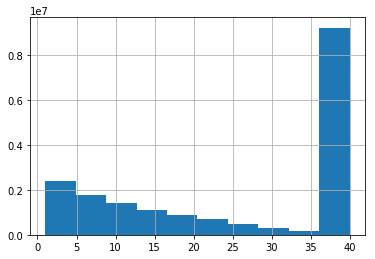

In [132]:
# checkr recency distribution
data.Recency1.hist()

In [133]:
# remove first X weeks
data = data[data.Week > 100]

In [134]:
# check dimensions
print(data.shape)

(9262054, 179)


In [135]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx       8777296
CustomerInterest     484758
Recency2            1939793
Recency3              23386
Recency4              13040
Recency5             323434
Recency6             277632
MeanPrice            579350
StdPrice             580204
MeanYield            579350
StdYield             580204
MeanZScore           579350
StdZScore            580204
YieldMarktDelta      579350
ZScoreMarktDelta     579350
dtype: int64

In [136]:
# export CSV
data.to_csv("../data/prepared/data_v3_80_100.csv", index = False, compression = "gzip")